# 1. Data Analysis

In [1]:
# Download and unzip data
!mkdir ~/.kaggle/
!mv /content/kaggle.json ~/.kaggle/
!kaggle datasets download -d kritanjalijain/amazon-reviews --unzip

100% 1.29G/1.29G [00:42<00:00, 42.7MB/s]
100% 1.29G/1.29G [00:42<00:00, 32.6MB/s]


In [2]:
import pandas as pd
import numpy as np

In [11]:
train_data = pd.read_csv('train.csv', names=['polarity', 'heading', 'text'])
test_data = pd.read_csv('test.csv', names=['polarity', 'heading', 'text'])

Now we will look at the size of data and the class distributions

In [ ]:
print(len(train_data), len(test_data))

3600000 400000


In [12]:
train_data.dropna(inplace=True, axis=0)
test_data.dropna(inplace=True, axis=0)

In [13]:
train_data['polarity'][train_data['polarity'] == 1] = 0
train_data['polarity'][train_data['polarity'] == 2] = 1
test_data['polarity'][test_data['polarity'] == 1] = 0
test_data['polarity'][test_data['polarity'] == 2] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

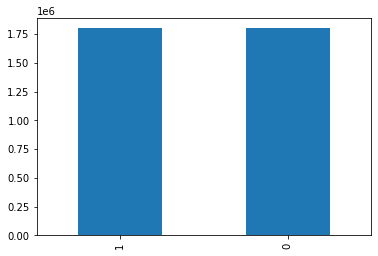

In [14]:
train_data['polarity'].value_counts().plot(kind='bar')

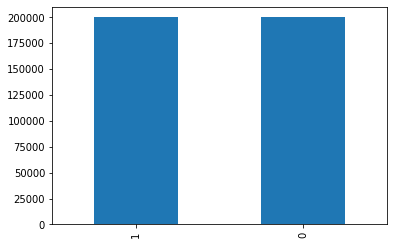

In [15]:
test_data['polarity'].value_counts().plot(kind='bar')

We can see from the plots that the dataset is well balanced between the 2 classes (1 for negative and 2 for positive)

In [83]:
train_data['text'].apply(lambda x: len(x.split())).describe()

count    3.599923e+06
mean     7.416861e+01
std      4.229854e+01
min      1.000000e+00
25%      3.900000e+01
50%      6.600000e+01
75%      1.030000e+02
max      2.540000e+02
Name: text, dtype: float64

In [84]:
test_data['text'].apply(lambda x: len(x.split())).describe()  

count    399990.000000
mean         74.107458
std          42.257920
min           2.000000
25%          39.000000
50%          66.000000
75%         103.000000
max         217.000000
Name: text, dtype: float64

We can see from the above statistics that the train and test data token counts are maximum 254, and 75% at 103 tokens. This will be useful in the tokenization step

# 2. Data Preprocessing

We will use Bert pre-trained model and tokenizer to get embeddings for heading and text together. Bert tokenizer is responsible for tokenization and padding and truncation, in this setup we will truncate and pad all tokens to length 128 which is reasonable given the analysis result shown before

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.5 MB/s 
     |████████████████████████████████| 182 kB 95.8 MB/s 
     |████████████████████████████████| 7.6 MB 57.6 MB/s 


In [6]:
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, logging
logging.set_verbosity_error()
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.zero_grad()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
def encode_bert(heading, text, tokenizer, model, device):
  tokenized = tokenizer(text=heading, text_pair=text, return_tensors='pt', max_length=128, truncation=True, truncation_strategy='only_second', padding=True, pad_to_multiple_of=128)
  tokenized.to(device)
  embedding = model(**tokenized)[1]
  return embedding.cpu()

In [8]:
def data_loader(df, batch_size):
  n = len(df) // batch_size
  remaining = len(df) % batch_size
  for i in range(n):
    yield df[i*batch_size:(i+1)*batch_size]
  yield df[n*batch_size:]

In [ ]:
DEVICE = torch.device('cuda')
bert_model.to(DEVICE)
bert_model.eval()
batch_size = 256

train_dataloader = data_loader(train_data, batch_size)
test_dataloader = data_loader(test_data, batch_size)
train_embeddings = []
with torch.no_grad():
  for batch in tqdm(train_dataloader, total= (len(train_data) // batch_size)):
    embeddings = encode_bert(list(batch['heading']), list(batch['text']), bert_tokenizer, bert_model, DEVICE)
    train_embeddings.append(embeddings)
  train_embeddings = torch.vstack(train_embeddings).cpu().numpy()
  test_embeddings = []
  for batch in tqdm(test_dataloader, total= (len(test_data) // batch_size)):
    embeddings = encode_bert(list(batch['heading']), list(batch['text']), bert_tokenizer, bert_model, DEVICE)
    test_embeddings.append(embeddings)
  test_embeddings = torch.vstack(test_embeddings).cpu().numpy()

14063it [9:20:45,  2.39s/it]


In [ ]:
X_train = train_embeddings
X_test = test_embeddings
y_train = train_data.polarity.values.astype(int)
y_test = test_data.polarity.values.astype(int)

In [ ]:
np.savez_compressed('dataset', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)